## Setup database connectivity

We'll reuse our module from the previous notebook (***`database_connectivity_setup.ipynb`***) to establish connectivity to the database

In [1]:
%run 'database_connectivity_setup.ipynb'

Your connection object is ***`conn`***:
1. Queries: You can run your queries using ***```psql.read_sql("""<YOUR SQL>""", conn)```***.
2. Create/Delete/Updates: You can run these statements using ***```psql.execute("""<YOUR SQL>""", conn)```***, followed by a ***```conn.commit()```*** command to ensure your transaction is committed. Otherwise your changes will be rolledback if you terminate your kernel.

If you created a new connection object (say to connect to a new cluster) as shown in the last section of `00_database_connectivity_setup.ipynb` notebook, use that connection object where needed.

#### Import the Necessary Python Packages

In [2]:
%matplotlib inline
import numpy as np
import math as math
import seaborn as sns
import pylab
from matplotlib import pyplot as plt

#### Example sensor data creation: we will assume a sinusoid corrupted with additive white Gaussian noise

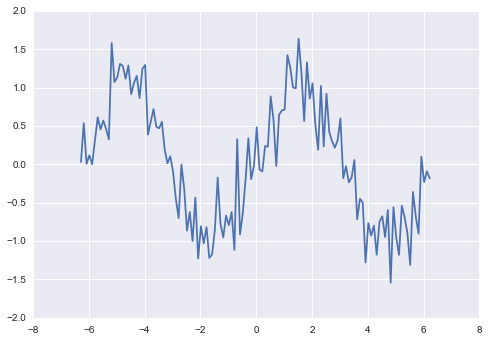

In [4]:
ts = np.arange(-2*math.pi,2*math.pi,step=0.1)
sigma = 0.1+0.3*np.random.uniform(0,1,1)
f = np.sin(ts) + np.random.normal(0,sigma,len(ts))
plt.plot(ts,f)
plt.show()

#### We will now create the sensor input table for smoothing using SQL window functions lead and lag (Greenplum or HAWQ)

In [5]:
sql = """
    DROP TABLE IF EXISTS iot.conv_sensor_input;
"""
psql.execute(sql,conn)

sql = """
    CREATE TABLE iot.conv_sensor_input (        
        run_number int,
        ts float8,
        f float8
    ) DISTRIBUTED BY (run_number);
"""
psql.execute(sql,conn)
conn.commit()

#### Insert one time series into the table

In [7]:
ts = np.arange(-2*math.pi,2*math.pi,step=0.1)
sigma = 0.1+0.3*np.random.uniform(0,1,1)
f = np.sin(ts) + np.random.normal(0,sigma,len(ts))
for j in np.arange(0,len(ts)):
    sql = """
        INSERT INTO iot.conv_sensor_input VALUES (
            {run_number},
            {tp},
            {fp}
        );
    """.format(
            run_number=str(1),
            tp = str(ts[j]),
            fp = str(f[j])
        )
    psql.execute(sql,conn)
conn.commit()

#### We will now perform smoothing using SQL window functions lead and lag in GPDB/HAWQ

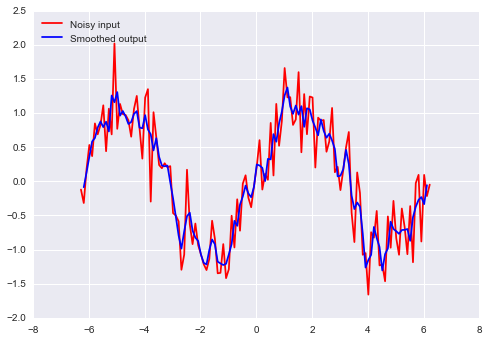

In [8]:
sql = """
    SELECT
        run_number,
        array_agg(ts ORDER BY ts) as ts_arr,
        array_agg(f ORDER BY ts) as f_arr,
        array_agg(fs ORDER BY ts) as fs_arr
    FROM (
        SELECT
            run_number,
            ts,
            f,
            (
                f + 
                lead(f,1) OVER (PARTITION BY run_number ORDER BY ts) +
                lag(f,1) OVER (PARTITION BY run_number ORDER BY ts)
            )/3.0 as fs
        FROM
            iot.conv_sensor_input
        ORDER BY ts
    ) q
    WHERE run_number = 1
    GROUP BY 1
"""
df = psql.read_sql(sql,conn)
time = np.array(df.loc[0]['ts_arr'])
signal = np.array(df.loc[0]['f_arr'])
smoothed_signal = np.array(df.loc[0]['fs_arr'])
pylab.plot(time,signal,color='r',label='Noisy input')
pylab.plot(time,smoothed_signal,color='b', label='Smoothed output')
pylab.legend(loc='upper left')
plt.show()

In [9]:
conn.close()